In [2]:
#loading the images 
#loading content image
from google.colab import files
upload = files.upload()

Saving dinesh11.jpg to dinesh11.jpg


In [3]:
# loading style image
upload = files.upload()

Saving style1.jpg to style1.jpg


In [4]:
!ls

dinesh11.jpg	       generated_frog500.png  real_frog400.png
gan.h5		       generated_frog600.png  real_frog500.png
generated_frog0.png    my_dir		      real_frog600.png
generated_frog100.png  real_frog0.png	      sample_data
generated_frog200.png  real_frog100.png       style1.jpg
generated_frog300.png  real_frog200.png
generated_frog400.png  real_frog300.png


In [0]:
from keras.preprocessing.image import load_img, img_to_array
target_image_path = 'dinesh11.jpg'
style_reference_image_path = 'style1.jpg'

width,height = load_img(target_image_path).size
img_height = 400
img_width = int(width*img_height/height)


In [0]:
# auxillary functions
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
  img = load_img(image_path, target_size = (img_height , img_width))
  img = img_to_array(img)
  img = np.expand_dims(img, axis = 0)
  img = vgg19.preprocess_input(img)
  return img

def deprocess_image(x):
  x[:,:,0] += 103.939
  x[:,:,1] += 166.779
  x[:,:,2] += 123.68
  x = x[:,:,::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  return x

  

In [8]:
# loading the pretrained VGG19 network and applying it to the three images
from keras import backend as K
import tensorflow as tf
import os

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, img_height , img_width , 3))

input_tensor = K.concatenate([target_image,
                             style_reference_image,
                             combination_image], axis = 0)

model = vgg19.VGG19(input_tensor = input_tensor,
                   weights = 'imagenet',
                   include_top = False)

print ('Model loaded.')

Model loaded.


In [0]:
def content_loss(base , combination):
  return K.sum(K.square(combination - base))

In [0]:
# define style loss
def gram_matrix(x):
  features = K.batch_flatten(K.permute_dimensions(x,(2,0,1)))
  gram = K.dot(features , K.transpose(features))
  return gram

def style_loss(style , combination):
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = img_height * img_width
  return K.sum(K.square(C -S))/ (4. * (channels ** 2)*(size **2))

In [0]:
# total variation loss
def total_variation_loss(x):
  a = K.square(
      x[:,:img_height - 1, :img_width-1,:]-
      x[:,1:,:img_width - 1 ,:])
  b = K.square(
      x[:,:img_height -1,:img_width-1,:]-
      x[:,:img_height -1,1:,:])
  return K.sum(K.pow(a+b, 1.25))

In [0]:
# higher content weight means more recognizable image

In [13]:
# Dict mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Name of layer used for content loss
content_layer = 'block5_conv2'
# Name of layers used for style loss
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# Weights in the weighted average of the loss components
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# Define the loss by adding all components to a `loss` variable
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

In [0]:
# setting the gradient process
grads = K.gradients(loss, combination_image)[0]
fetch_loss_and_grads = K.function([combination_image],[loss, grads])

class Evaluator(object):
  
  def __init__(self):
    self.loss_value = None
    self.grads_values = None
    
  def loss(self, x):
    assert self.loss_value is None
    x = x.reshape((1, img_height, img_width, 3))
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    self.loss_value = loss_value
    self.grad_values = grad_values
    return self.loss_value
  
  def grads(self, x):
    assert self.loss_value is not None
    grad_values = np.copy(self.grad_values)
    self.loss_value = None
    self.grad_values = None
    return grad_values
  
evaluator = Evaluator()

In [18]:
# style transfer loop
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

result_prefix = 'my_result'
iterations = 20

x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
  print ('Start of iteration', i)
  start_time = time.time()
  x , min_val , info  = fmin_l_bfgs_b(evaluator.loss,
                                     x,
                                     fprime = evaluator.grads,
                                     maxfun = 20)
  print ('Current loss value:', min_val)
  img = x.copy().reshape((img_height , img_width, 3))
  img = deprocess_image(img)
  fname = result_prefix + '_at_iteration_%d.png' % i
  imsave(fname , img)
  print ('Image saved as ', fname)
  end_time= time.time()
  print ('Iteration %d completed in %ds'% (i, end_time - start_time))

Start of iteration 0
Current loss value: 44853543000.0
Image saved as  my_result_at_iteration_0.png
Iteration 0 completed in 14s
Start of iteration 1
Current loss value: 9756750000.0
Image saved as  my_result_at_iteration_1.png
Iteration 1 completed in 14s
Start of iteration 2
Current loss value: 4150560500.0
Image saved as  my_result_at_iteration_2.png
Iteration 2 completed in 14s
Start of iteration 3
Current loss value: 2351001600.0
Image saved as  my_result_at_iteration_3.png
Iteration 3 completed in 15s
Start of iteration 4
Current loss value: 1621346400.0
Image saved as  my_result_at_iteration_4.png
Iteration 4 completed in 14s
Start of iteration 5
Current loss value: 1264459300.0
Image saved as  my_result_at_iteration_5.png
Iteration 5 completed in 15s
Start of iteration 6
Current loss value: 1048051100.0
Image saved as  my_result_at_iteration_6.png
Iteration 6 completed in 14s
Start of iteration 7
Current loss value: 893711300.0
Image saved as  my_result_at_iteration_7.png
Itera

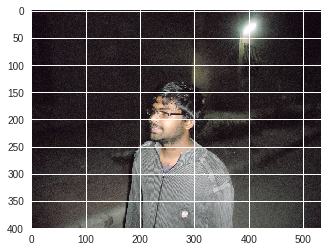

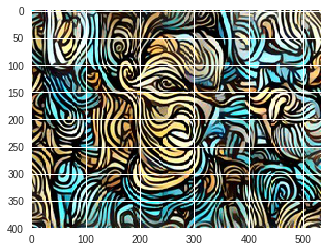

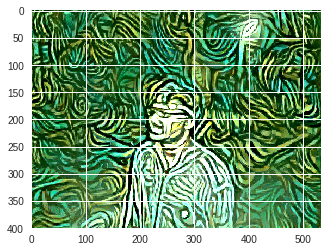

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

#content image
plt.imshow(load_img(target_image_path, target_size = (img_height , img_width)))
plt.figure()

#style image
plt.imshow(load_img(style_reference_image_path,target_size = (img_height , img_width)))
plt.figure()

# generated image
plt.imshow(img)
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('dinesh.png', bbox_inches = 'tight')

In [0]:
files.download('dinesh.png') 